# Modelo

Modelo: LightGBM

Dataset: eliminamos variables con datadrifting (cprestamos_personales y mprestamos_personales), el resto del feature engineering consiste en sumar algunas variables que tenia sentido agrupar, promedios moviles considerando los ultimos 3 meses (incluido el mes corriente), pendiente (slope) sobre la misma ventana de tiempo que los promedios moviles.

Estrategia de entrenamiento: solo abril

In [1]:
# %pip install scikit-learn==1.3.2
# %pip install seaborn==0.13.1
# %pip install numpy==1.26.4
# %pip install matplotlib==3.7.1
# %pip install pandas==2.1.4
# %pip install lightgbm==4.4.0
# %pip install optuna==3.6.1

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle

c:\Users\Cristian Burich\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
base_path = '/home/cburich_pymnts/buckets/b1/'


dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_02_fe_U_k210.csv'

ganancia_acierto = 273000
costo_estimulo = 7000

# agregue sus semillas
semillas = [165229,165211,165203,165237,165247]

data = pd.read_csv(dataset_path + dataset_file)

In [ ]:
data = data.drop(columns=['clase_ternaria_1'])

In [4]:
data['foto_mes'].value_counts()

202108    165442
202107    165152
202106    164876
202105    164623
202104    164090
202103    163685
202102    162646
202101    162026
Name: foto_mes, dtype: int64

In [5]:
data.shape

(1312540, 476)

In [6]:
# nos quedamos con las features de Boruta

# with open("features_boruta.txt", "r") as f:
#     selected_columns = [line.strip() for line in f]

# data = data[selected_columns]

In [7]:
data.shape # se crean los lags y demases para todos los registros, no aumenta cantidad de columnas respecto a modelo base

(1312540, 476)

In [ ]:
meses_train = [202007, 202008, 202009, 202010, 202011, 202012, 202101, 202102, 202103, 202104, 202105,202106] 

In [ ]:
# # Asignamos pesos a las clases

# data['clase_peso'] = 1.0

# data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
# data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [ ]:
# data['clase_binaria1'] = 0
# data['clase_binaria2'] = 0
# data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)
# data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

Para evaluar la calidad del modelo, crearemos nuestra propia función de evaluación que calcule la ganancia. La razón de incluir los pesos es precisamente para poder implementar esta función de evaluación de manera adecuada. Al combinar las clases *BAJA+1* y *BAJA+2* en una sola, necesitamos una forma de diferenciarlas, y es aquí donde entra en juego el *weight*. Este parámetro nos permitirá distinguir entre ambas clases al momento de evaluarlas dentro del algoritmo.


In [ ]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True



# Parámetros del modelo.
params = {
    'objective': 'binary',
    'metric': 'gan_eval',
    'boosting_type': 'gbdt',
    'max_bin': 31,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.7,
    'verbose': 0
}

In [12]:
train_data = data[data['foto_mes'].isin(meses_train)]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1'] # Solo BAJA+2
y_train_binaria2 = train_data['clase_binaria2'] # junta a los 2 BAJA
w_train = train_data['clase_peso']

In [13]:
X_train.shape

(981946, 475)

# Optimizacion

A continuación, procederemos a optimizar **LightGBM** utilizando la librería **Optuna**.


In [16]:
def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 8, 100), 
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.05), # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 1000),
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0),
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'verbose': -1
    }
    
    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria2, # considera a los 2 BAJA en la misma categoria
                              weight=w_train)
    
    # print(f"Learning Rate: {learning_rate}, Type: {type(learning_rate)}")
    
    # Use callbacks for early stopping
  #  early_stopping_cb = lgb.early_stopping(stopping_rounds=50)
        
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=100, # era 1000
       # callbacks=[early_stopping_cb],
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )
    
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5

In [ ]:
storage_name = "sqlite:///" + db_path + "optimization_lgbm.db" # una copia del archivo se encuentra en la carpeta "final model" con el resto de los archivos que generan la prediccion final
study_name = "exp_210_v00"  # EDITAR EDITAR EDITAR

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2024-11-19 11:05:42,939] A new study created in RDB with name: exp_207bo_lgbm_v01


In [ ]:
study.optimize(objective, n_trials=100)

[I 2024-11-19 11:07:19,974] Trial 0 finished with value: 593887000.0 and parameters: {'num_leaves': 94, 'learning_rate': 0.008872901890166596, 'min_data_in_leaf': 308, 'feature_fraction': 0.5217424510545546, 'bagging_fraction': 0.5325453881977024}. Best is trial 0 with value: 593887000.0.
[I 2024-11-19 11:07:58,941] Trial 1 finished with value: 561638000.0 and parameters: {'num_leaves': 20, 'learning_rate': 0.02252479132797573, 'min_data_in_leaf': 38, 'feature_fraction': 0.6585536871120609, 'bagging_fraction': 0.7055266441736655}. Best is trial 0 with value: 593887000.0.
[I 2024-11-19 11:08:32,295] Trial 2 finished with value: 570850000.0 and parameters: {'num_leaves': 18, 'learning_rate': 0.034968371540462374, 'min_data_in_leaf': 980, 'feature_fraction': 0.948996356499851, 'bagging_fraction': 0.3994662842129779}. Best is trial 0 with value: 593887000.0.
[I 2024-11-19 11:09:14,586] Trial 3 finished with value: 580153000.0 and parameters: {'num_leaves': 63, 'learning_rate': 0.0077479214

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
plot_param_importances(study)

El **learning rate** es un parámetro que tiene que ir acompañado por más árboles.

In [ ]:
plot_slice(study)

In [ ]:
plot_contour(study)

In [ ]:
plot_contour(study, params=['num_leaves','min_data_in_leaf'] )

Y finalmente tomamos el mejor modelo y lo entrenamos con la totalidad de los datos

In [21]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


Mejor cantidad de árboles para el mejor model 100


Variables más importantes para el modelo:

In [ ]:
importances = model.feature_importance()
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df[importance_df['importance'] > 0]


,feature,importance
144,slope_ctrx_quarter,201
36,Master_fechaalta,195
134,slope_mcuentas_saldo,181
70,avg3_mrentabilidad_annual,163
127,slope_mrentabilidad_annual,155
...,...,...
153,slope_Visa_cadelantosefectivo,1
136,slope_ctarjeta_master,1
44,Visa_madelantopesos,1
29,ccajas_otras,1


Para guardar el modelo para poder utilizarlo más adelante, no es necesario guardarlo como *pickle*, la librería nos permite guardarlo en formato texto

In [ ]:
model.save_model(modelos_path + 'lgb_210.txt') # EDITAR EDITAR EDITAR

# Backtesting

In [ ]:

train_data = data[data['foto_mes'].isin([202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012, 202101, 202102, 202103, 202104] )]  # 202101, 
test_data = data[data['foto_mes'] == 202106]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']

In [69]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

Mejor cantidad de árboles para el mejor model 100


In [70]:
train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

In [71]:
model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


obtenemos la predicción de **Junio**

In [72]:
y_pred_lgm = model.predict(X_test)

In [73]:
ganancia = np.where(y_test_binaria1 == 1, ganancia_acierto, 0) - np.where(y_test_binaria1 == 0, costo_estimulo, 0)

idx = np.argsort(y_pred_lgm)[::-1]

ganancia = ganancia[idx]
y_pred_lgm = y_pred_lgm[idx]

ganancia_cum = np.cumsum(ganancia)


Cantidad optima de envios:

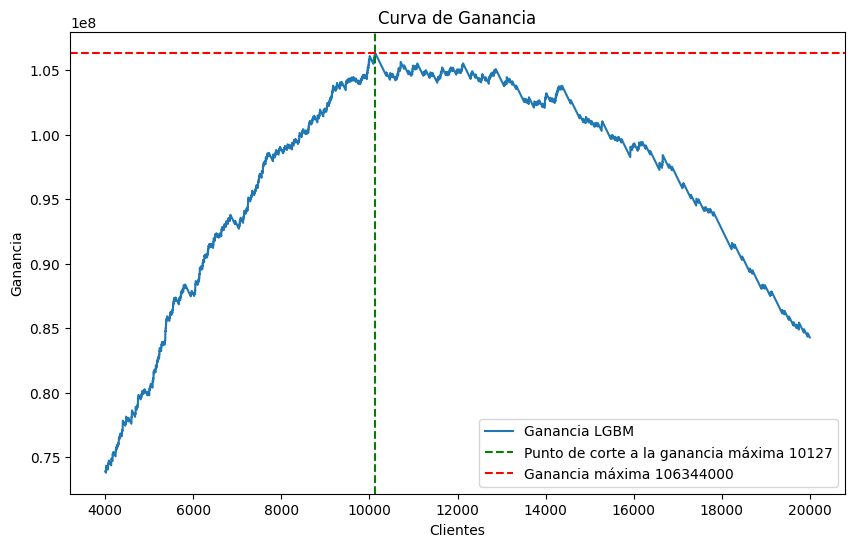

In [74]:
piso_envios = 4000
techo_envios = 20000

ganancia_max = ganancia_cum.max()
gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]

plt.figure(figsize=(10, 6))
plt.plot(range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios), ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.axvline(x=gan_max_idx, color='g', linestyle='--', label=f'Punto de corte a la ganancia máxima {gan_max_idx}')
plt.axhline(y=ganancia_max, color='r', linestyle='--', label=f'Ganancia máxima {ganancia_max}')
plt.title('Curva de Ganancia')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()


In [75]:
gan_max_idx

10127

#### Proba

In [76]:
ganancia = np.where(y_test_binaria1 == 1, ganancia_acierto, 0) - np.where(y_test_binaria1 == 0, costo_estimulo, 0)

idx = np.argsort(y_pred_lgm)[::-1]

ganancia = ganancia[idx]
y_pred_lgm = y_pred_lgm[idx]

ganancia_cum = np.cumsum(ganancia)

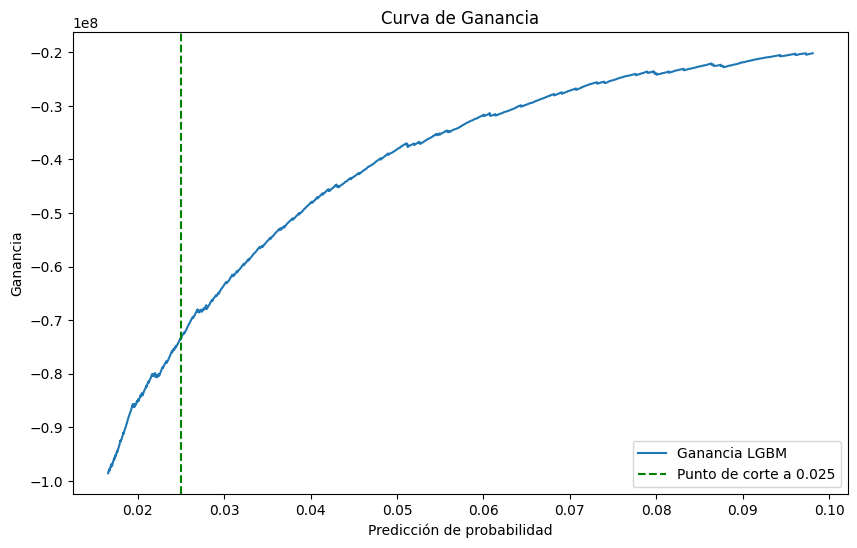

In [77]:
piso_envios = 4000
techo_envios = 20000

plt.figure(figsize=(10, 6))
plt.plot(y_pred_lgm[piso_envios:techo_envios], ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.title('Curva de Ganancia')
plt.xlabel('Predicción de probabilidad')
plt.ylabel('Ganancia')
plt.axvline(x=0.025, color='g', linestyle='--', label='Punto de corte a 0.025')
plt.legend()
plt.show()

## Semillerío

In [78]:
import random

# Semilla inicial para reproducibilidad
initial_seed = 165229
random.seed(initial_seed)

# Generar 20 semillas adicionales
semillero = [random.randint(0, 200000) for _ in range(10)]

print(semillero)

[106155, 34606, 89410, 108671, 169966, 87163, 136553, 69545, 60768, 93527]


In [ ]:
def ganancia_prob(y_pred, y_true, prop = 1):
  ganancia = np.where(y_true == 1, ganancia_acierto, 0) - np.where(y_true == 0, costo_estimulo, 0)
  return ganancia[y_pred >= 0.025].sum() / prop

# Esto esta mal, deberias calcular ganancia en función de envíos

In [80]:
ganancia_results= []

for seed in semillero:
    params['seed'] = seed

    model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)
    
    y_pred_lgm = model.predict(X_test)

    ganancia = ganancia_prob(y_pred_lgm, y_test_binaria1)
    ganancia_results.append(ganancia)
    print(f"Ganancia LGBM con seed {seed}: {ganancia}")

Ganancia LGBM con seed 106155: 100408000.0
Ganancia LGBM con seed 34606: 99421000.0
Ganancia LGBM con seed 89410: 100058000.0
Ganancia LGBM con seed 108671: 101780000.0
Ganancia LGBM con seed 169966: 101752000.0
Ganancia LGBM con seed 87163: 100821000.0
Ganancia LGBM con seed 136553: 103250000.0
Ganancia LGBM con seed 69545: 101584000.0
Ganancia LGBM con seed 60768: 101801000.0
Ganancia LGBM con seed 93527: 100968000.0


In [81]:
average_ganancia = np.mean(ganancia_results)
print(f"Ganancia promedio: {average_ganancia}")

Ganancia promedio: 101184300.0


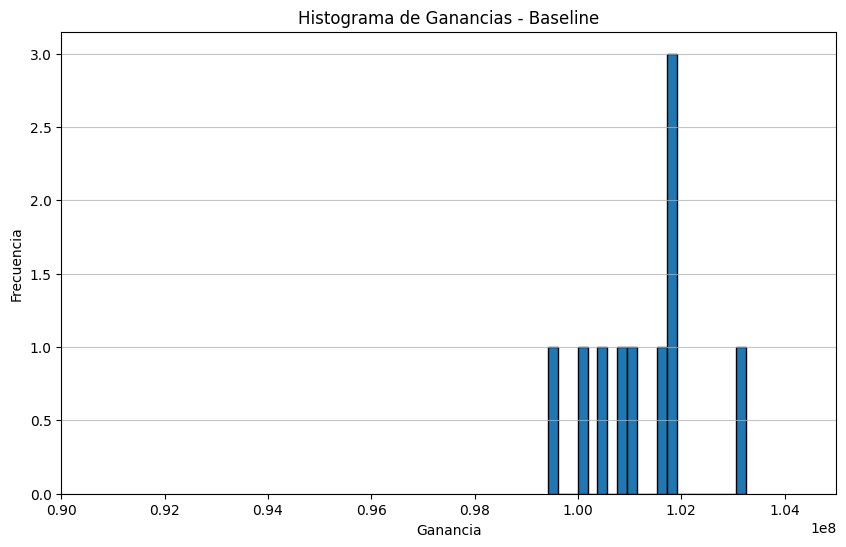

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(ganancia_results, bins=20, edgecolor='black')
# plt.xlim(9e7, 10.5e7)
plt.title('Histograma de Ganancias - Baseline')
plt.xlabel('Ganancia')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Generar prediccion para Kaggle

In [ ]:
# Mejores parametros que habian surgido de la optimizacion de Optuna

best_iter = study.best_trial.user_attrs["best_iter"]

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

# y cantidad optima de envios segun backtesting  

# EDITAR


corte = 11000

In [ ]:
train_data = data[data['foto_mes'].isin([202007, 202008, 202009, 202010, 202011, 202012, 202101, 202102, 202103, 202104, 202105,202106] )] 
future_data = data[data['foto_mes'] == 202108]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = future_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)

In [103]:
train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

In [104]:
model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


In [105]:
y_pred_lgm = model.predict(X_test)

In [106]:
# Agrego la prediccion en el dataset de test
X_test['pred_lgm'] = y_pred_lgm

#  ordeno por probabilidad para marcar a quienes les vamos a enviar el estimulo
idx = np.argsort(y_pred_lgm)[::-1]
X_test.reset_index(drop=True, inplace=True) # reseteo el index para poder ordenar por idx, sino en index tenia por default el numero de fila del dataframe original "data"
X_test = X_test.iloc[idx]

# genero la columna con 1s para los que van a recibir el estimulo, 0 para todo el resto
envios = np.zeros(len(X_test), dtype=int)
envios[:corte] = 1
X_test['Predicted'] = envios


Genero el archivo para kaggle

In [ ]:
output = X_test[['numero_de_cliente', 'Predicted']]

file_name = 'results_210_v0.csv'  # EDITAR, EDITAR, EDITAR
output_path = base_path + 'exp/KA2000/' + file_name

output.to_csv(output_path, index=False)